# Investigate use of ECAPE on ERA5 data

For the MCS env cond paper, reviewer #3 suggested we could try ECAPE, as it is better at predicting w that CAPE.
For an in-depth description of ECAPE, see [peters2023][1]. It is a version of entraining CAPE, where the cloud radius is predicted
from the storm relative flow. This allows the calculation of a fractional entrainment, using r$^{-2}$ scaling (not the more familiar r$^{-1}$ scaling in convection parametrization schemes).
I have taken the Python implementation of ECAPE used in [peters2023][1], and found here [figshare code][2]. I have stripped out unneeded parts at mapped the code onto the paper. 
I have tested this against another high-quality implementation [github_capella2024][3], and get generally good agreement provided the same input CAPE is used.

In another notebook, I have made sure that the values for geometric altitude that I can calculate from ERA5 data are sensible.

ECAPE takes as inputs:
* T, q, u, v, p, z (altitude).

p and z require calculation (see other notebook, and [4]). With this, it *should* be possible to calc ECAPE anywhere on the ERA5 domain.

This is what I investigate in this notebook.

[1]: https://doi.org/10.1175/JAS-D-23-0003.1
[2]: https://doi.org/10.6084/m9.figshare.21859818.v5
[3]: https://github.com/citylikeamradio/ecape
[4]: https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height

In [1]:
import sys
from itertools import product

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units
import numpy as np
import xarray as xr

from IPython.display import clear_output

# Contains previous code for calculating pressure from lnsp.
from mcs_prime.era5_calc import ERA5Calc

sys.path.insert(0, '/home/users/mmuetz/projects/ecape_calc')
from ecape_calc import compute_CAPE_CIN, compute_NCAPE, compute_VSR, compute_ETILDE
from params import T1, T2

/home/users/mmuetz/projects/mcs_prime/mcs_prime/mcs_prime_config_util.py:69: UserWarning: Warning: path missing era5dir: /does/not/exist
  warnings.warn(f"Warning: path missing {k}: {path}")


In [2]:
basepath = '/badc/ecmwf-era5/data/oper/an_ml/2020/01/01/'

paths = [
    basepath + f'ecmwf-era5_oper_an_ml_202001010000.{v}.nc' 
    for v in ['lnsp', 'z', 't', 'q', 'u', 'v']
]

ds = xr.open_mfdataset(paths).isel(time=0).sel(latitude=slice(60, -60)).load()


In [3]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 481, level: 137)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... -59.5 -59.75 -60.0
    time       datetime64[ns] 2020-01-01
  * level      (level) int32 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137
Data variables:
    lnsp       (latitude, longitude) float32 11.53 11.53 11.53 ... 11.49 11.49
    q          (level, latitude, longitude) float32 1.697e-06 ... 0.002732
    t          (level, latitude, longitude) float32 213.7 214.0 ... 271.8 271.8
    u          (level, latitude, longitude) float32 54.83 53.61 ... -6.256
    v          (level, latitude, longitude) float32 26.96 25.83 ... 2.979 2.944
    z          (latitude, longitude) float32 2.34 5.023 -9.281 ... -1.234 -3.918
Attributes:
    Conventions:  CF-1.6
    history:      2020-04-06 11:19:13 GMT by grib_to_netcdf-2.14.0: grib_to_n...

In [4]:
Rd = 287.06
g = 9.80665
# As used by IFS: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-SpatialreferencesystemsandEarthmodel
Re = 6371229 # m

In [5]:
class Era5ComputeAlt:
    """Compute geopotential (z) from netcdf data, then compute altitude (alt)
    
    Code taken from existing code for doing the same for GRIB data"""
    def __init__(self, ds):
        self.ds = ds
        self.e5calc = ERA5Calc('/gws/nopw/j04/mcs_prime/mmuetz/data/ERA5/ERA5_L137_model_levels_table.csv')


    def run(self):
        T = self.ds.t.values
        q = self.ds.q.values
        p = self.e5calc.calc_pressure(self.ds.lnsp.values)
        self.p = p
        zsfc = self.ds.z.values
        
        # Get levels in ascending order of height (starts at 137)
        levels = self.ds.level.values[::-1]
        # print(levels)

        # 0.609133 = Rv/Rd - 1.
        # TODO: Why extra RD
        Tv = T * (1. + 0.609133 * q) * Rd
        z_h = zsfc

        z = np.zeros_like(p)
        for lev in levels:
            lev_idx = lev - 1
            # print(lev, lev_idx)
            z_h, z_f = self.compute_z_level(lev_idx, p, Tv, z_h)
            z[lev_idx] = z_f

        h = z / g
        alt = Re * h / (Re - h)

        self.z = z
        self.h = h
        self.alt = alt
        return z, h, alt

    def compute_z_level(self, lev_idx, p, Tv, z_h):
        '''Compute z at half & full level for the given level, based on T/q/sp'''
        # compute the pressures (on half-levels)
        # ph_lev, ph_levplusone = get_ph_levs(values, lev)
        ph_lev, ph_levplusone = p[lev_idx - 1], p[lev_idx]
    
        if lev_idx == 0:
            dlog_p = np.log(ph_levplusone / 0.1)
            alpha = np.log(2)
        else:
            dlog_p = np.log(ph_levplusone / ph_lev)
            alpha = 1. - ((ph_lev / (ph_levplusone - ph_lev)) * dlog_p)
    
        # z_f is the geopotential of this full level
        # integrate from previous (lower) half-level z_h to the
        # full level
        z_f = z_h + (Tv[lev_idx] * alpha)
    
        # z_h is the geopotential of 'half-levels'
        # integrate z_h to next half level
        z_h = z_h + (Tv[lev_idx] * dlog_p)
    
        return z_h, z_f

In [6]:
comp_alt = Era5ComputeAlt(ds)
_ = comp_alt.run()

In [7]:
import datetime as dt
from timeit import default_timer as timer

class LoopPercentageDisp:
    def __init__(self, L, step_percentage=10, fmt='{percentage:.1f}% ({i}/{L}): elapsed: {elapsed:.1f}s, est dur: {est_duration:.1f}s - est end: {est_end_time}'):
        self.L = L
        self.step_percentage = step_percentage
        self.disp_percentage = step_percentage
        self.fmt = fmt
        self.curr_percentage = 0
        self.start_time = None

    def __call__(self, i):
        L = self.L
        frac = i / L
        percentage = frac * 100
        
        if not self.start_time:
            self.start_time = dt.datetime.now()
            print(f'Start at: {self.start_time}')
            self.start = timer()
            elapsed = 0
        else:
            self.curr = timer()
            elapsed = self.curr - self.start
            
            est_duration = elapsed / frac
            est_end_time = self.start_time + dt.timedelta(seconds=elapsed)

        if percentage >= self.disp_percentage:
            print(self.fmt.format(
                percentage=percentage, 
                i=i, 
                L=L, 
                elapsed=elapsed, 
                est_duration=est_duration, 
                est_end_time=est_end_time
            ))
            self.disp_percentage += self.step_percentage
        self.curr_percentage = percentage

In [8]:
def compute_ECAPE_etc(ds, comp_alt, lon_idx, lat_idx):
    # ERA5 indexes levels from highest to lowest.
    levlatlon_idx = (slice(None, None, -1), lat_idx, lon_idx)
    T0 = ds.t.values[levlatlon_idx]
    q0 = ds.q.values[levlatlon_idx]
    u0 = ds.u.values[levlatlon_idx]
    v0 = ds.v.values[levlatlon_idx]
    p0 = comp_alt.p[levlatlon_idx]
    z0_msl = comp_alt.alt[levlatlon_idx]
    z0 = z0_msl - z0_msl[0]  # Convert into height above surface.

    CAPE, CIN, LFC, EL = compute_CAPE_CIN(T0, p0, q0, 0, 0, 0, z0, T1, T2)
    
    if not (np.isnan(LFC) or np.isnan(EL)) and CAPE > 100:
        NCAPE, MSE0_star, MSE0bar = compute_NCAPE(T0, p0, q0, z0, T1, T2, LFC, EL)
        
        # Get the 0-1 km mean storm-relative wind, estimated using bunkers2000 method for right-mover storm motion
        V_SR, C_x, C_y = compute_VSR(z0, u0, v0)
        
        # Get e_tilde, which is the ratio of ecape to cape.  also, varepsilon is the fracitonal entrainment rate, and radius is the theoretical upraft radius
        Etilde, varepsilon, radius = compute_ETILDE(CAPE, NCAPE, V_SR, EL, 120)
        ECAPE = CAPE * Etilde
    
        return dict(
            CAPE=CAPE,
            CIN=CIN,
            LFC=LFC,
            EL=EL,
            NCAPE=NCAPE,
            V_SR=V_SR,
            Etilde=Etilde,
            varepsilon=varepsilon,
            radius=radius,
            ECAPE=Etilde * CAPE,
        )
    else:
        return dict(
            CAPE=CAPE,
            CIN=CIN,
            LFC=LFC,
            EL=EL,
            NCAPE=None,
            V_SR=None,
            Etilde=None,
            varepsilon=None,
            radius=None,
            ECAPE=None,
        )

In [9]:
%%timeit
compute_ECAPE_etc(ds, comp_alt, 0, 240)

13.4 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
print(f'Time to run over full domain: {481 * 1440 * 0.0128 / 3600:.3f}h')
print(f'Time to run over 1/100 domain: {0.01 * 481 * 1440 * 0.0128 / 60:.3f}m')

Time to run over full domain: 2.463h
Time to run over 1/100 domain: 1.478m


In [11]:
lons = list(range(0, 1440, 10))
lats = list(range(0, 481, 10))
output = np.full((10, len(lats), len(lons)), np.nan)
lpd = LoopPercentageDisp(len(lons))
for i, lon_idx in enumerate(lons):
    lpd(i)
    for j, lat_idx in enumerate(lats):
        # print(lon_idx, lat_idx)
        try:
            ecape_dict = compute_ECAPE_etc(ds, comp_alt, lon_idx, lat_idx)
            for k, key in enumerate(ecape_dict.keys()):
                output[k, j, i] = ecape_dict[key]
        except Exception as e:
            # output[(lon_idx, lat_idx)] = e
            pass


Start at: 2024-07-15 11:19:41.457328
10.4% (15/144): elapsed: 3.5s, est dur: 33.5s - est end: 2024-07-15 11:19:44.942161
20.1% (29/144): elapsed: 7.9s, est dur: 39.4s - est end: 2024-07-15 11:19:49.384670
30.6% (44/144): elapsed: 12.4s, est dur: 40.5s - est end: 2024-07-15 11:19:53.831207
40.3% (58/144): elapsed: 16.5s, est dur: 40.9s - est end: 2024-07-15 11:19:57.920389
50.0% (72/144): elapsed: 20.4s, est dur: 40.9s - est end: 2024-07-15 11:20:01.900937
60.4% (87/144): elapsed: 24.7s, est dur: 40.9s - est end: 2024-07-15 11:20:06.164974
70.1% (101/144): elapsed: 28.1s, est dur: 40.1s - est end: 2024-07-15 11:20:09.568373
80.6% (116/144): elapsed: 31.8s, est dur: 39.5s - est end: 2024-07-15 11:20:13.240953
90.3% (130/144): elapsed: 36.3s, est dur: 40.2s - est end: 2024-07-15 11:20:17.766956


In [12]:
lon = ds.longitude.values[lons]
lat = ds.latitude.values[lats]

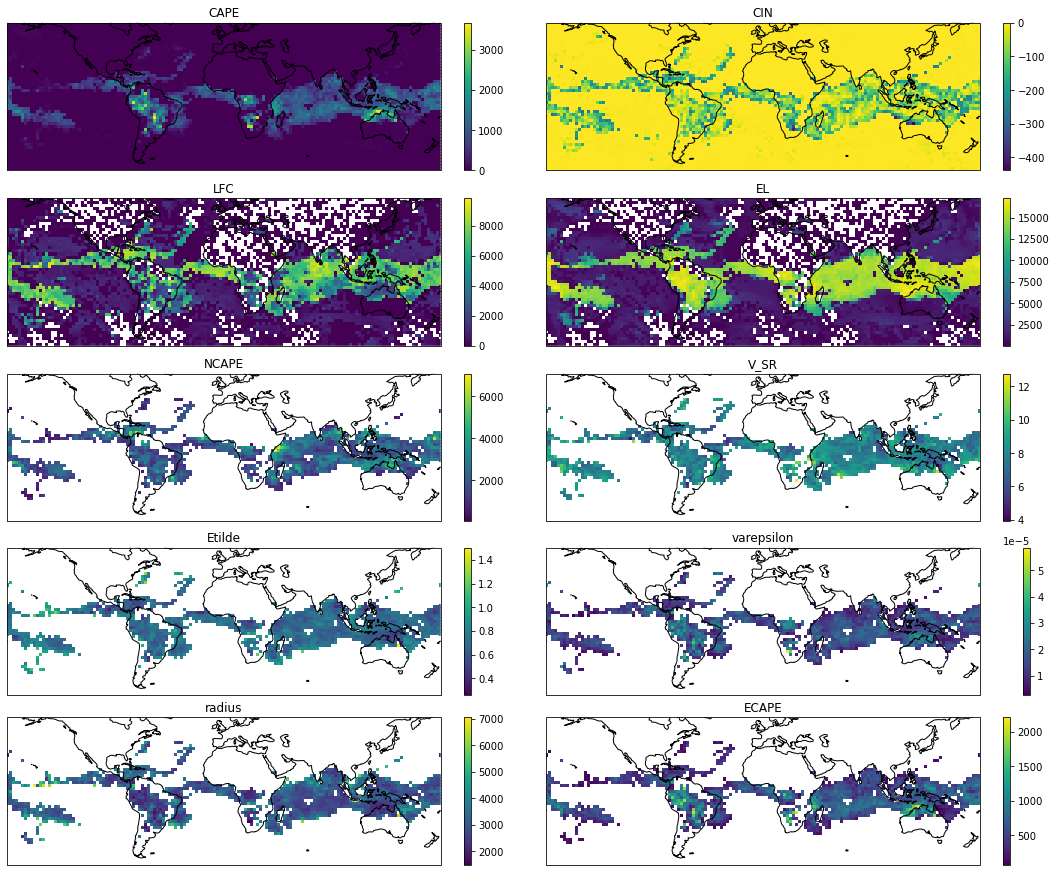

In [13]:
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, layout='constrained', subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 12)
for i, (key, ax) in enumerate(zip(ecape_dict.keys(), axes.flatten())):
    ax.set_title(key)
    im = ax.pcolormesh(lon, lat, output[i])
    plt.colorbar(im, ax=ax)
    ax.coastlines()

In [14]:
nanmask = ~np.isnan(output[-1])

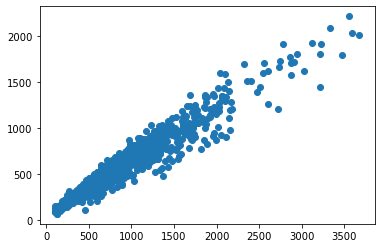

In [15]:
plt.scatter(output[0][nanmask], output[9][nanmask])

In [16]:
import pandas as pd
import seaborn as sns

In [17]:
o2 = []
for i in range(10):
    o2.append(output[i][nanmask])
o2 = np.array(o2)

In [18]:
df = pd.DataFrame(o2.T, columns=ecape_dict.keys())

In [19]:
df

CAPE         CIN          LFC            EL        NCAPE  \
0     123.284376 -159.040786  5789.574389   8121.523564   509.006893   
1     381.215164 -105.301759  5550.435231   9954.183120  1156.633953   
2     146.448612   -0.000005    10.830020   5870.380176   591.172074   
3     232.214703    0.000000     0.000000   6173.931909   707.289124   
4     107.215189   -0.000007    10.929966   5080.225832   457.850073   
...          ...         ...          ...           ...          ...   
1316  103.155971  -63.749254  5722.003779   7732.885528   238.203554   
1317  136.996361  -91.381219  7090.954280  10072.499869   904.499088   
1318  109.243139 -169.779632  6512.526801  11276.590451  1320.353652   
1319  211.825044   -6.996791  3521.694740   7984.071657   576.049819   
1320  206.353204   -1.195925   967.730843   8008.925824   902.654668   

           V_SR    Etilde  varepsilon       radius       ECAPE  
0     10.563519  1.303250    0.000007  4189.344298  160.670355  
1      7.629382  0.761281    0.000017  2759.339081  290.212047  
2      8.679186  0.992035    0.000019  2616.416752  145.282143  
3      8.663449  0.880604    0.000024  2315.183223  204.489145  
4      8.617270  1.085037    0.000021  2512.292227  116.332410  
...         ...       ...         ...          ...         ...  
1316   7.762913  1.154934    0.000011  3404.147324  119.138335  
1317   8.860065  1.057908    0.000006  4588.424163  144.929515  
1318   8.128146  0.989062    0.000004  5457.934233  108.048235  
1319   7.404163  0.879594    0.000018  2680.639728  186.320022  
1320   7.854969  0.846358    0.000015  2946.483262  174.648610  

[1321 rows x 10 columns]

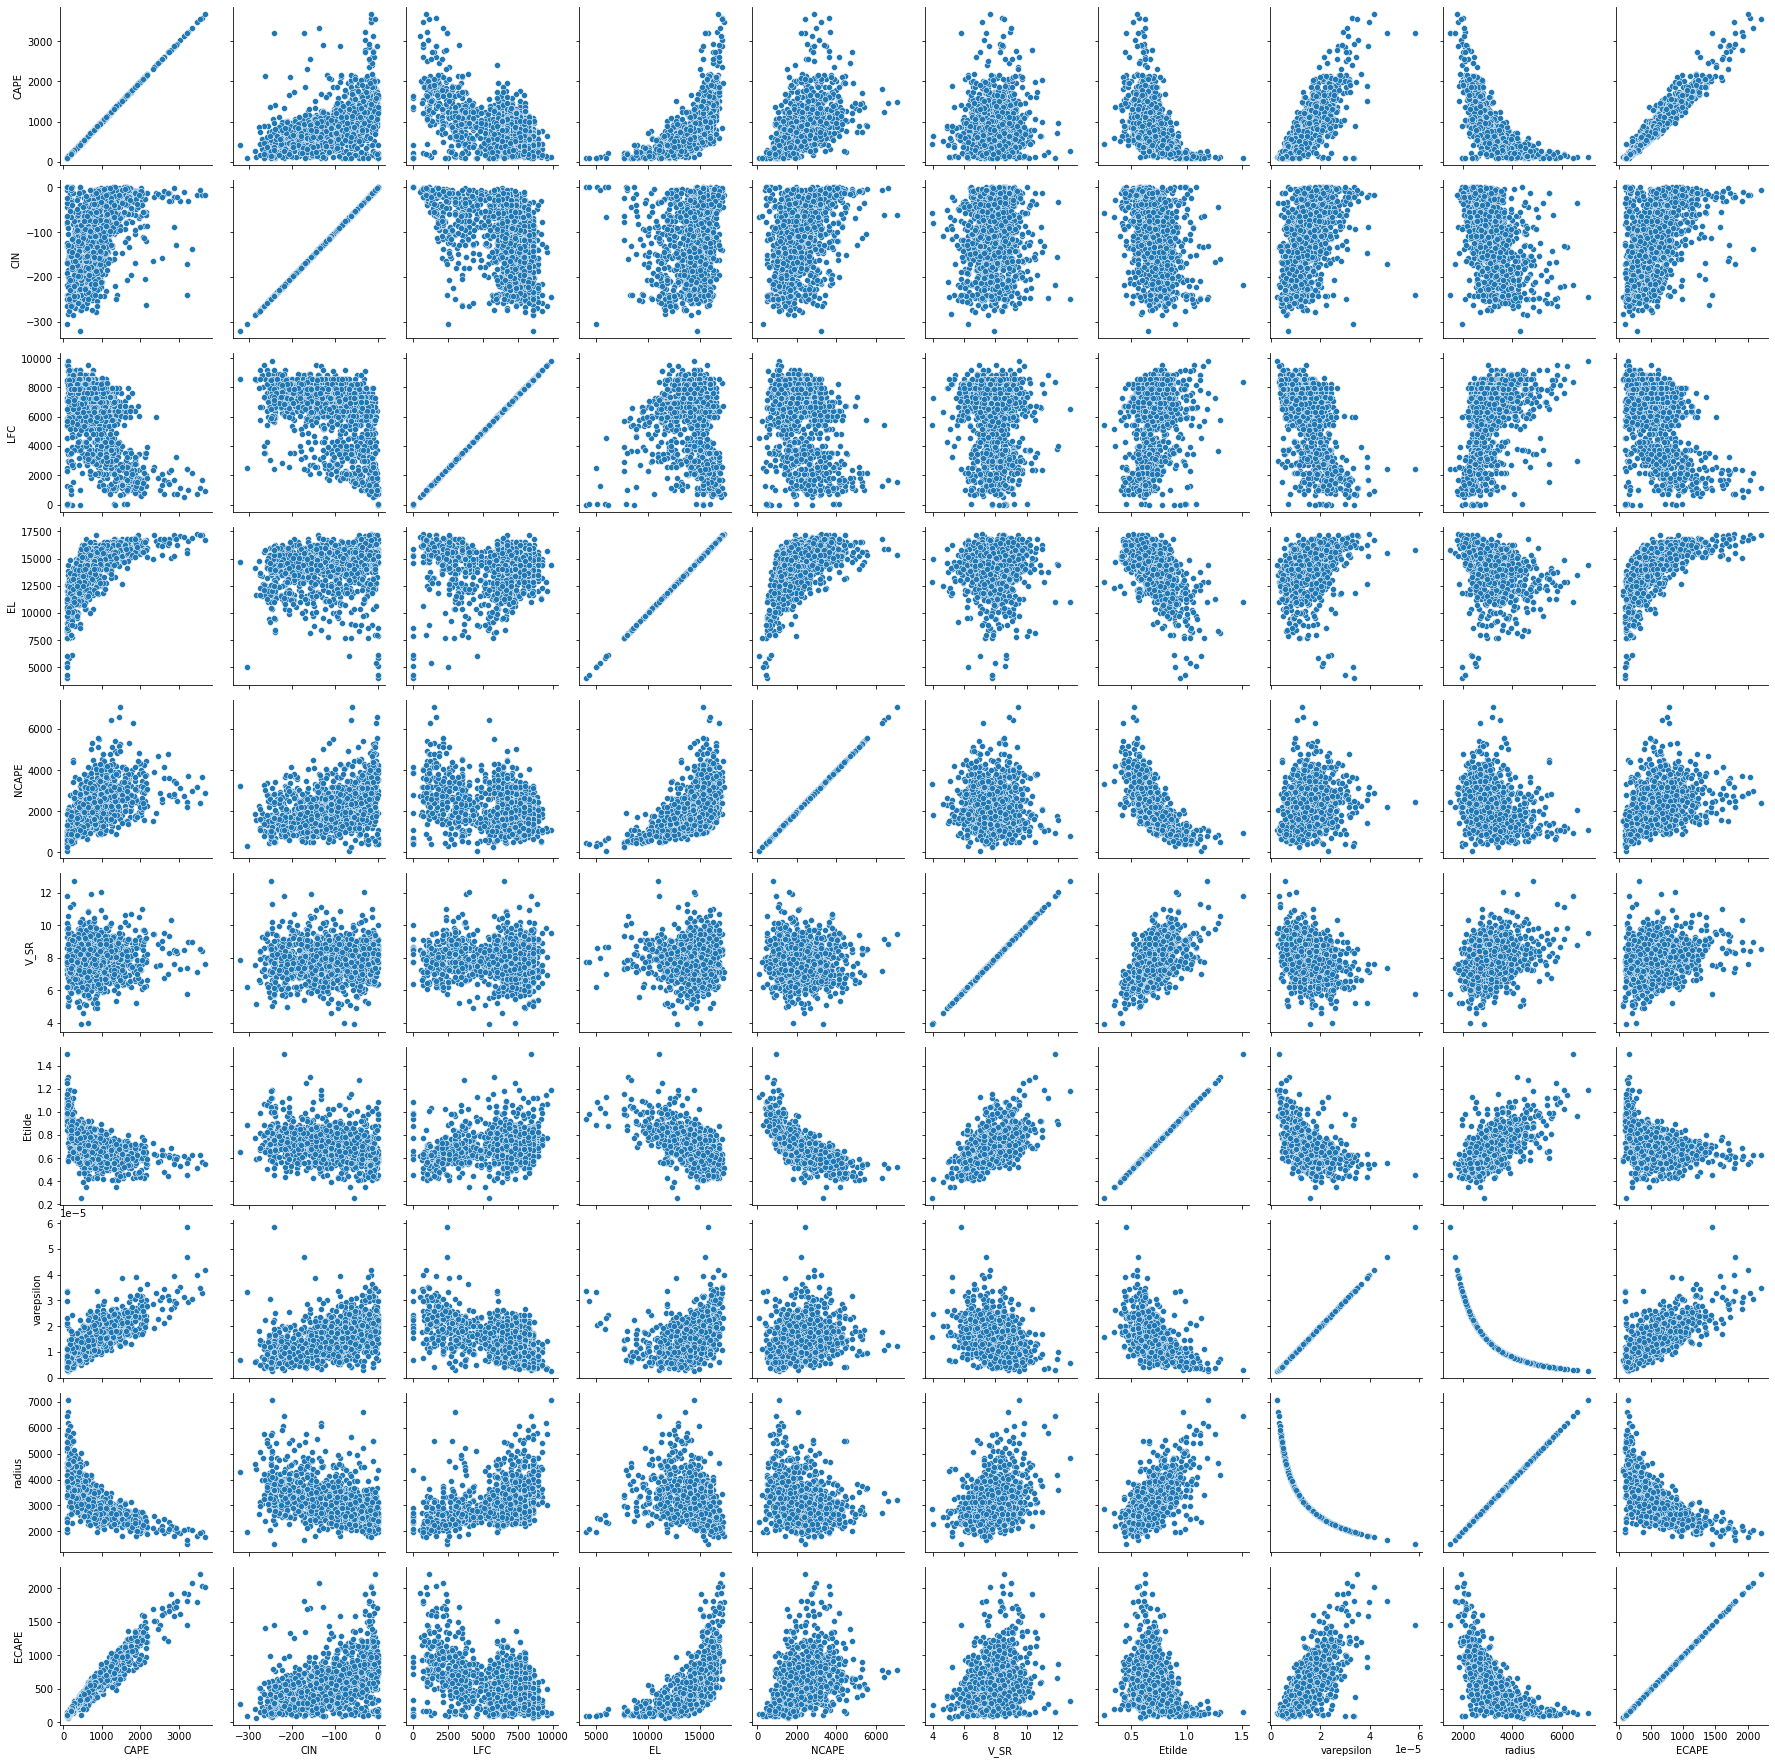

In [20]:
g = sns.PairGrid(df)
g.map(sns.scatterplot)

In [90]:
df.max()['CAPE']

3676.963800432296

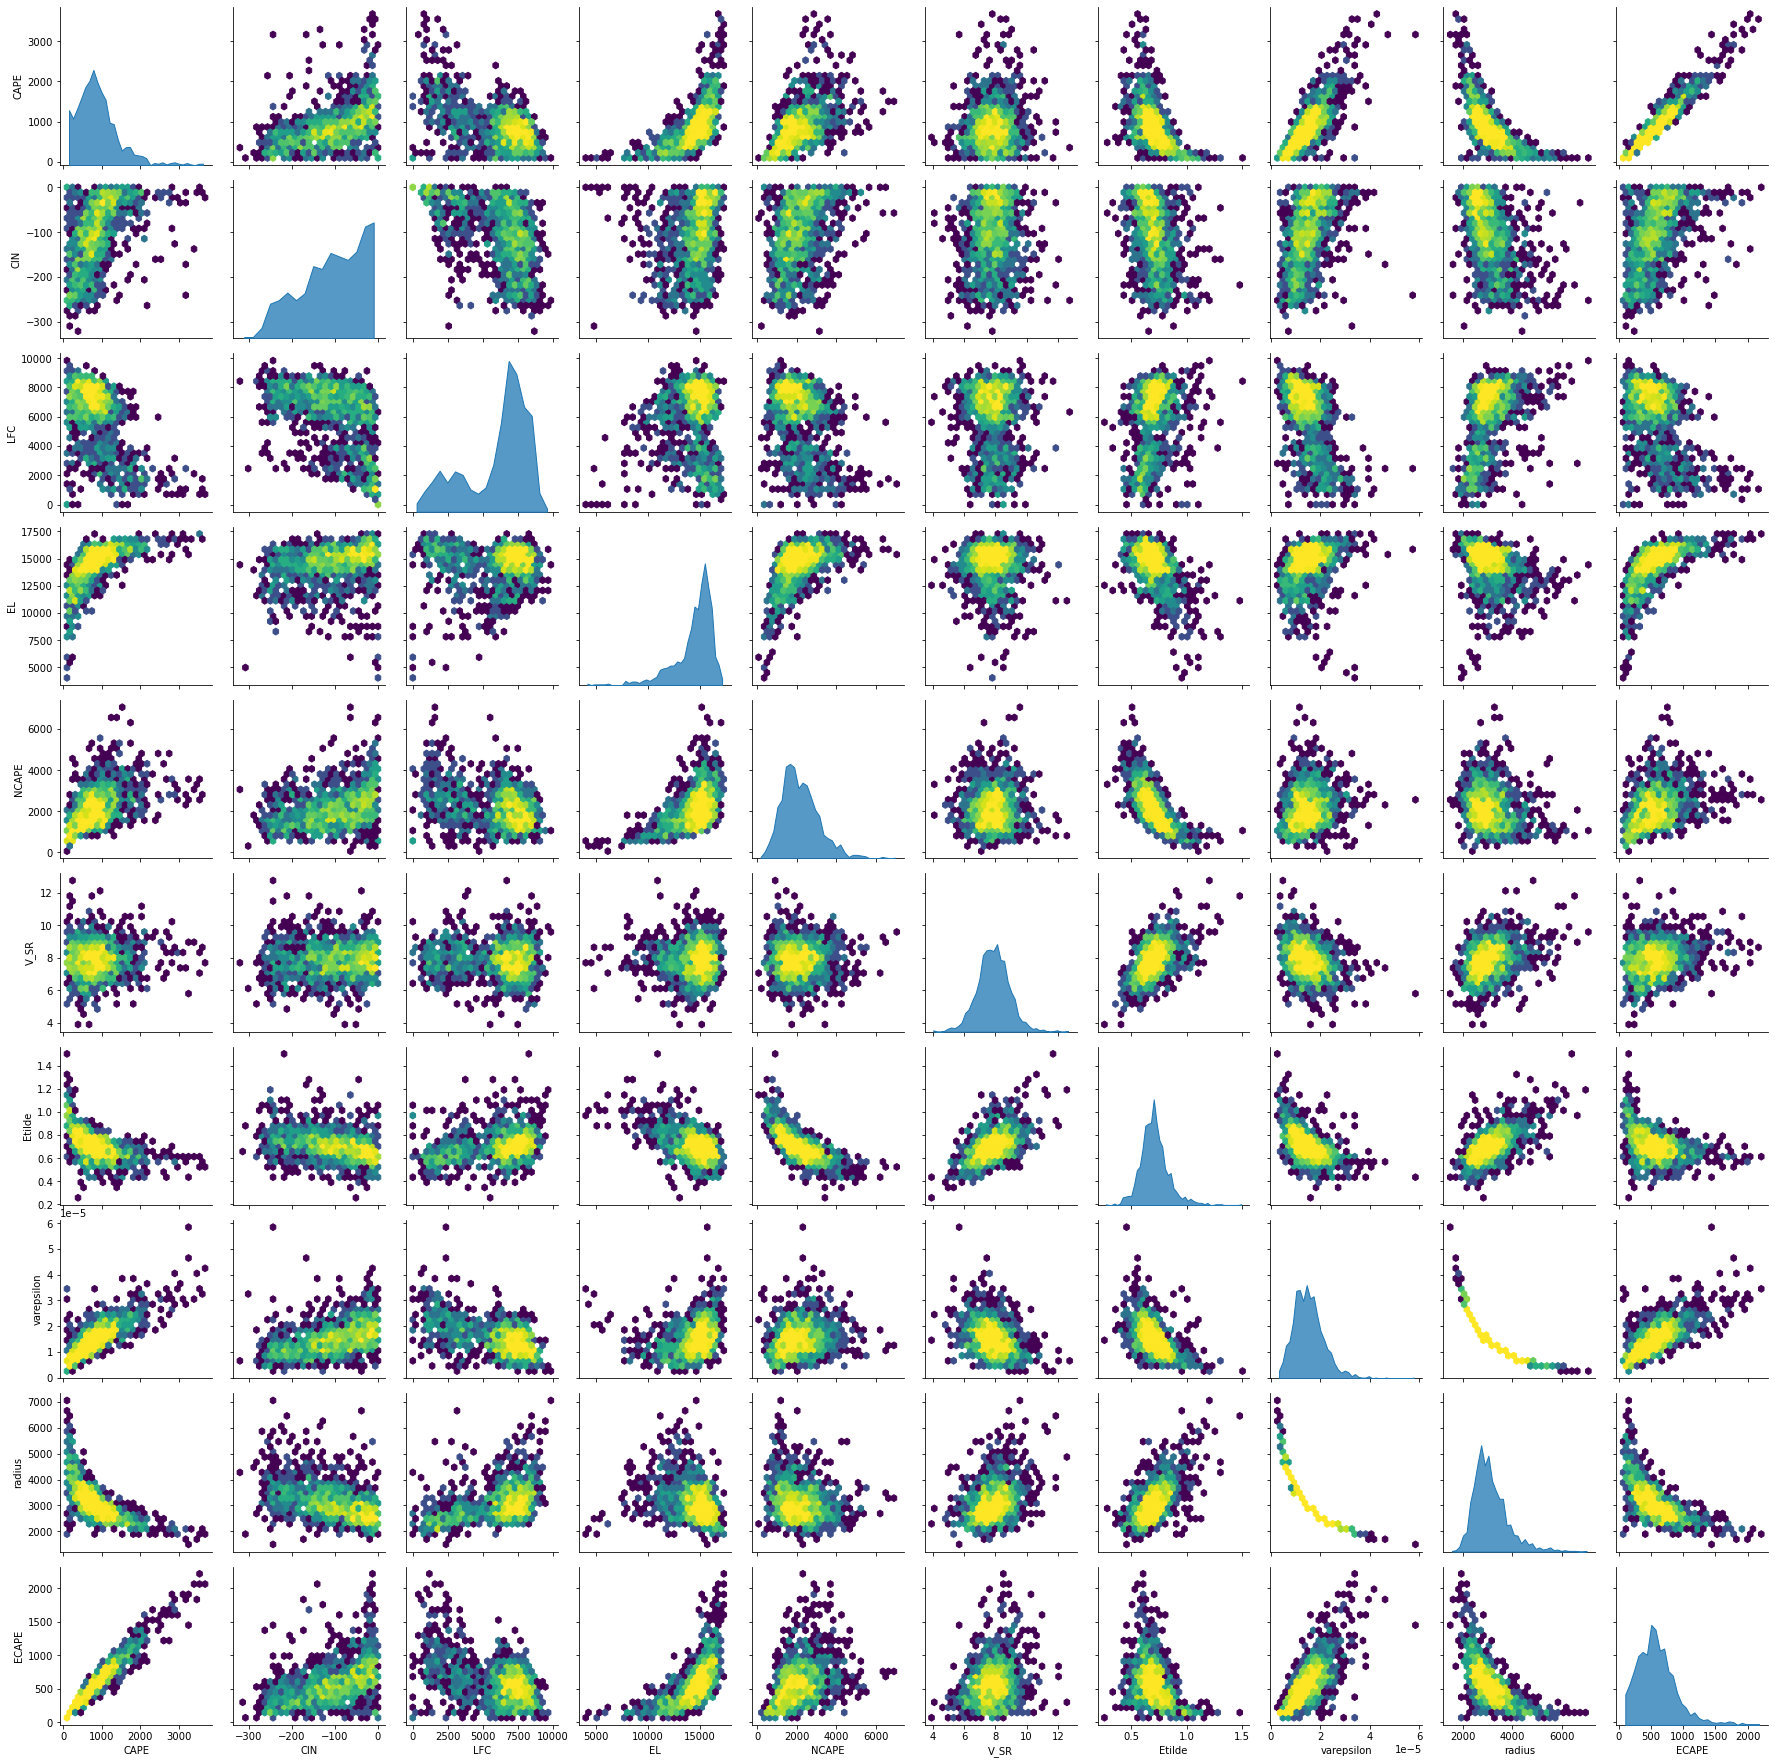

In [98]:
g = sns.PairGrid(df)
def hexbin(x, y, color, max_series=None, min_series=None, **kwargs):
    # cmap = sns.light_palette(color, as_cmap=True)
    ax = plt.gca()
    xmin, xmax = min_series[x.name], max_series[x.name]
    ymin, ymax = min_series[y.name], max_series[y.name]
    plt.hexbin(x, y, gridsize=25, extent=[xmin, xmax, ymin, ymax], **kwargs)
g.map_diag(sns.histplot, element='poly')
g.map_offdiag(hexbin, max_series=df.max(), min_series=df.min(), norm=LogNorm())

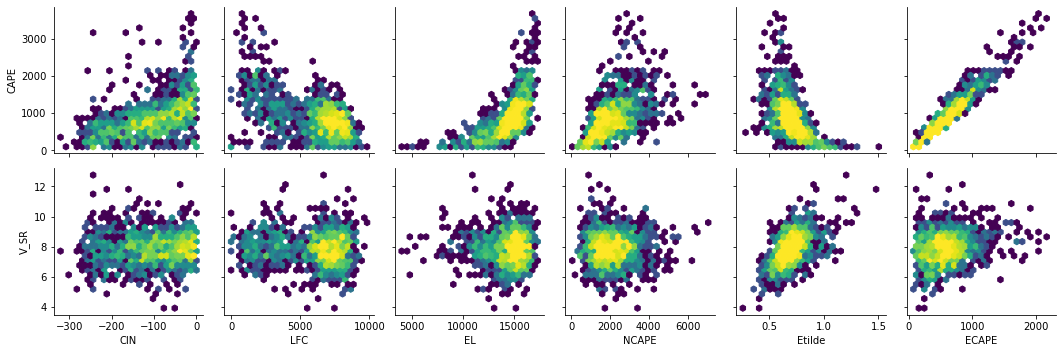

In [99]:
g = sns.PairGrid(df, x_vars=['CIN', 'LFC', 'EL', 'NCAPE', 'Etilde', 'ECAPE'], y_vars=['CAPE', 'V_SR'])
g.map_offdiag(hexbin, max_series=df.max(), min_series=df.min(), norm=LogNorm())


In [22]:
from scipy.stats import linregress
from matplotlib.colors import LogNorm

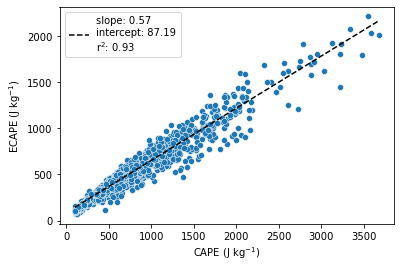

In [23]:
lr = linregress(df.CAPE, df.ECAPE)
sns.scatterplot(df, x='CAPE', y='ECAPE')
# sns.jointplot(x=df.CAPE, y=df.ECAPE, kind="hex", norm=LogNorm())
x = np.array([df.CAPE.min(), df.CAPE.max()])
y = lr.slope * x + lr.intercept
plt.plot(x, y, 'k--', label=f'slope: {lr.slope:.2f}\nintercept: {lr.intercept:.2f}\nr$^2$: {lr.rvalue**2:.2f}')
plt.xlabel('CAPE (J kg$^{-1}$)')
plt.ylabel('ECAPE (J kg$^{-1}$)')
plt.legend()


In [24]:
from ecape_calc import (
    lift_parcel_adiabatic,
    compute_CAPE_CIN,
    compute_NCAPE,
    compute_VSR,
    compute_ETILDE,
)

from consts import *
from params import *

In [82]:
def plot_skewt(z0, p0, T0, q0, u0, v0, C_x, C_y, Etilde, CAPE, varepsilon, radius):
    # Compute dewpoint and temperature, assign units in accordance with metpy vernacular
    T = T0 * units.degK
    p = p0 * units.Pa
    e = mpcalc.vapor_pressure(p, q0 * units('kg/kg'))
    Td = mpcalc.dewpoint(e)
    for iz in np.arange(0, Td.shape[0], 1):
        T[iz] = max(T[iz], Td[iz].to('K'))

    # Compute lifted parcel properties for an undiluted parcel
    fracent = 0
    T_lif, Qv_lif, Qt_lif, B_lif = lift_parcel_adiabatic(
        T.magnitude, p0, q0, 0, fracent, 0, z0, T1, T2
    )
    T_rho = T_lif * (1 + (Rv / Rd) * Qv_lif - Qt_lif)
    T_rho = T_rho * units('K')

    # Plot the skew-t skeleton
    # params = {
    #     "ytick.color": "black",
    #     "xtick.color": "black",
    #     "axes.labelcolor": "black",
    #     "axes.edgecolor": "black",
    #     "font.size": 12,
    #     #"text.usetex": True,
    # }
    # plt.rcParams.update(params)

    gs = gridspec.GridSpec(3, 3)
    fig = plt.figure(figsize=(9, 9))
    # axs = plt.subplots(1, 2, constrained_layout=True)

    skew = SkewT(fig, rotation=45, subplot=gs[:, :2])

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot.
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    print(p.shape)
    print(u0.shape)
    p_ = p[p >= 9000 * units.Pa]
    u0_ = u0[p >= 9000 * units.Pa]
    v0_ = v0[p >= 9000 * units.Pa]
    skew.plot_barbs(p_[0::5], u0_[0::5], v0_[0::5], x_clip_radius=0.1, y_clip_radius=0.08)
    skew.ax.set_ylim(1020, 100)
    skew.ax.set_xlim(-20, 40)

    skew.ax.text(
        -15,
        900,
        f'CAPE: {CAPE:.0f} J kg$^{{-1}}$\n'
        f'ECAPE: {Etilde * CAPE:.0f} J kg$^{{-1}}$\n'
        f'$\widetilde{{\mathrm{{E}}}}_A$: {Etilde * 100:.0f}\%\n'
        f'R: {radius:.0f} m',
        ha="center",
        va="center",
        size=7,
        bbox=dict(boxstyle="square,pad=0.3", fc="lightblue", ec="steelblue", lw=2),
    )

    # Set some better labels than the default
    skew.ax.set_xlabel(f'Temperature (C)')
    skew.ax.set_ylabel(f'Pressure (hPa)')

    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

    # Calculate full parcel profile and add to plot as black line
    # prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    prof = T_rho.to('degC')
    skew.plot(p, prof, 'k', linewidth=2)
    T_rho0 = T.magnitude * (1 + (Rv / Rd - 1) * q0)
    T_rho0 = T_rho0 * units('K')

    skew.plot(p, T_rho0, 'r', linewidth=0.5)
    # skew.plot(p,T_rho.to('degC'),'k',linewidth=2)

    # Shade areas of CAPE and CIN
    try:
        skew.shade_cin(p, T_rho0.to('degC'), prof, Td)
    except:
        print('NO CIN')
    try:
        skew.shade_cape(p, T_rho0.to('degC'), prof)
    except:
        print('NO CAPE')

    fracent = varepsilon
    # prate=3e-5
    T_lif, Qv_lif, Qt_lif, B_lif = lift_parcel_adiabatic(
        T.magnitude, p0, q0, 0, fracent, 0, z0, T1, T2
    )
    ECAPE, ECIN, ELFC, EEL = compute_CAPE_CIN(T0, p0, q0, 0, fracent, 0, z0, T1, T2)
    # Compute density temeprature for the lifted parcel and assign units
    T_rho = T_lif * (1 + (Rv / Rd) * Qv_lif - Qt_lif)
    T_rho = T_rho * units('K')

    skew.plot(p, T_rho, 'b--', linewidth=1)
    prof = T_rho.to('degC')
    try:
        skew.shade_cape(p, T_rho0.to('degC'), prof, facecolor=(0.5, 0.5, 0.5, 0.75))
    except:
        print('NO CAPE')

    # An example of a slanted line at constant T -- in this case the 0
    # isotherm
    skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidths=0.5)
    skew.plot_moist_adiabats(linewidths=0.5)
    skew.plot_mixing_lines(linewidths=0.5)

    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)

    fplt = np.where(z0 <= 6000)[0]
    max_wind = np.sqrt(u0[fplt]**2 + v0[fplt]**2).max()
    limit = np.ceil(max_wind / 10) * 10
    h = Hodograph(ax_hod, component_range=limit + 5)
    h.add_grid(increment=limit / 2, linewidth=0.5)

    cmap = plt.get_cmap('autumn_r', len(fplt))
    h.plot_colormapped(
        u0[fplt],
        v0[fplt],
        np.floor(z0[fplt] / 1000),
        linewidth=2,
        cmap=plt.get_cmap('gist_rainbow_r', 6),
    )  # Plot a line colored by wind speed

    plt.xlim(-limit - 5, limit + 5)
    plt.ylim(-limit - 5, limit + 5)
    plt.tick_params(
        axis='both',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        left=False,
        top=False,  # ticks along the top edge are off
        labelleft=False,
        labelbottom=False,
    )  # labels along the bottom edge are off
    for mag in [limit / 2, limit]:
        plt.text(-5, -mag - 1, f'{mag:.0f} m s$^{{-1}}$', fontsize=8)
    # plt.text(-5, -41, 'm s$^{-1}$', fontsize=8)
    # TODO: what is this meant to plot?
    # storm relative motion I suspect.
    #plt.plot(C_x, C_y, 'ko', markersize=2.5)

    # plt.savefig('figs/sndfig.pdf')


In [83]:
def plot_profile(ds, comp_alt, lon_idx, lat_idx):
    # ERA5 indexes levels from highest to lowest.
    levlatlon_idx = (slice(None, None, -1), lat_idx, lon_idx)
    T0 = ds.t.values[levlatlon_idx]
    q0 = ds.q.values[levlatlon_idx]
    u0 = ds.u.values[levlatlon_idx]
    v0 = ds.v.values[levlatlon_idx]
    p0 = comp_alt.p[levlatlon_idx]
    z0_msl = comp_alt.alt[levlatlon_idx]
    z0 = z0_msl - z0_msl[0]  # Convert into height above surface.

    ecape_dict = compute_ECAPE_etc(ds, comp_alt, lon_idx, lat_idx)
    print(ecape_dict)
    Etilde = ecape_dict['Etilde']
    CAPE = ecape_dict['CAPE']
    varepsilon = ecape_dict['varepsilon']
    radius = ecape_dict['radius']
    plot_skewt(z0, p0, T0, q0, u0, v0, None, None, Etilde, CAPE, varepsilon, radius)


In [84]:
ecape_ptiles = np.nanpercentile(output[-1], np.arange(0, 101, 10))

{'CAPE': 119.56370666579184, 'CIN': -282.83630135043893, 'LFC': 8540.8582950539, 'EL': 11637.361566060114, 'NCAPE': 1559.1044348646903, 'V_SR': 5.152925, 'Etilde': 0.5895009175719801, 'varepsilon': 6.630350847204442e-06, 'radius': 4421.139779423566, 'ECAPE': 70.48291478779136}
(137,)
(137,)
CAPE %-tile 0


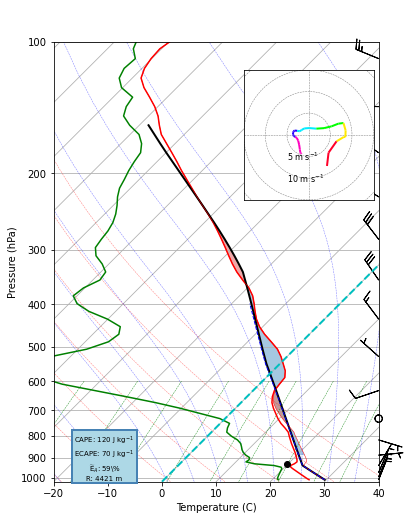

{'CAPE': 306.15769357787815, 'CIN': -211.95589250095117, 'LFC': 7278.186149051004, 'EL': 11290.34834062859, 'NCAPE': 1178.2188112802287, 'V_SR': 6.7146893, 'Etilde': 0.7359451542833872, 'varepsilon': 1.3261524797579532e-05, 'radius': 3126.1208996016926, 'ECAPE': 225.31527103521753}
(137,)
(137,)
CAPE %-tile 10


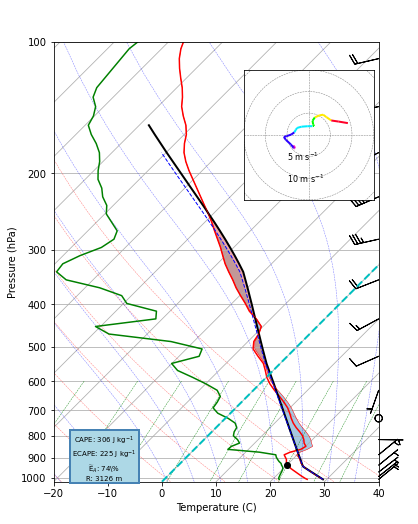

{'CAPE': 385.7727942845569, 'CIN': -174.23206150854222, 'LFC': 8253.07258603289, 'EL': 14418.217800118575, 'NCAPE': 1015.2956861149762, 'V_SR': 7.6158752, 'Etilde': 0.8494356837369874, 'varepsilon': 9.193241040071934e-06, 'radius': 3754.638915891505, 'ECAPE': 327.68917728023075}
(137,)
(137,)
CAPE %-tile 20


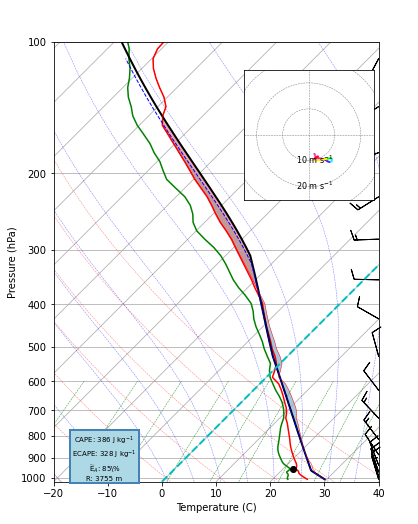

{'CAPE': 684.1010331782905, 'CIN': -122.62623025191348, 'LFC': 6046.329823478657, 'EL': 13681.684581095953, 'NCAPE': 2649.2562344521357, 'V_SR': 7.2391734, 'Etilde': 0.6049332295358092, 'varepsilon': 1.4270524464829093e-05, 'radius': 3013.578671844506, 'ECAPE': 413.83544732932705}
(137,)
(137,)
CAPE %-tile 30


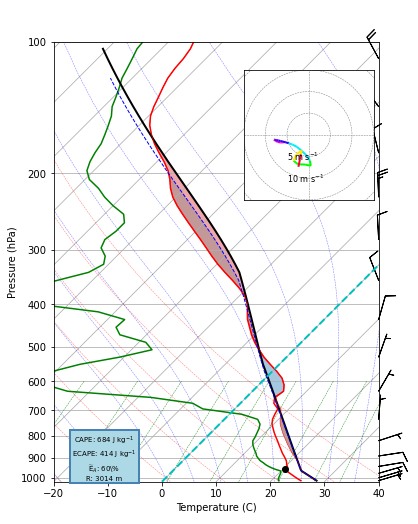

{'CAPE': 625.5182923544844, 'CIN': -200.85394806006343, 'LFC': 8589.796556884357, 'EL': 15028.663961995488, 'NCAPE': 1563.4717620944668, 'V_SR': 8.157172, 'Etilde': 0.7848753683701745, 'varepsilon': 1.1050706906086558e-05, 'radius': 3424.5812186095986, 'ECAPE': 490.95390013400845}
(137,)
(137,)
CAPE %-tile 40


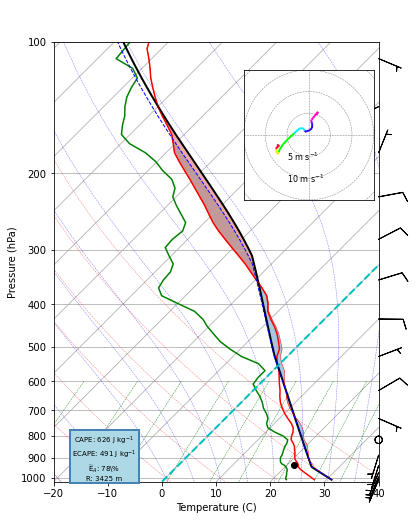

{'CAPE': 958.1959549236392, 'CIN': -61.94881046912416, 'LFC': 4004.9885584000444, 'EL': 14055.594706577704, 'NCAPE': 2346.3467050220256, 'V_SR': 6.7114234, 'Etilde': 0.5786003183409476, 'varepsilon': 2.1075341937094278e-05, 'radius': 2479.791608199285, 'ECAPE': 554.412484551826}
(137,)
(137,)
CAPE %-tile 50


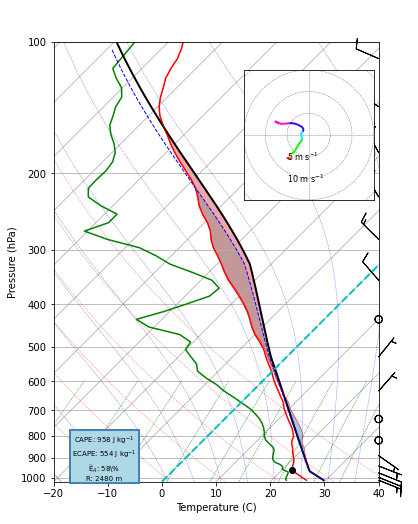

{'CAPE': 922.8110834030261, 'CIN': -109.83164147065726, 'LFC': 7320.060579911617, 'EL': 14677.065244055491, 'NCAPE': 2024.6196914833656, 'V_SR': 7.5941916, 'Etilde': 0.6768479873001781, 'varepsilon': 1.7007158314880365e-05, 'radius': 2760.4928305219623, 'ECAPE': 624.602824459635}
(137,)
(137,)
CAPE %-tile 60


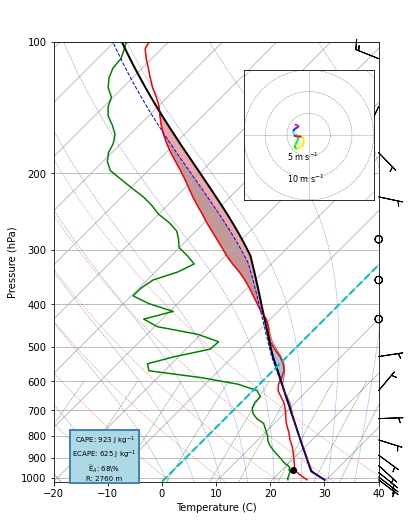

{'CAPE': 1148.0283361736695, 'CIN': -11.149870966666878, 'LFC': 6692.337861718706, 'EL': 15584.992330084893, 'NCAPE': 2902.2318986400464, 'V_SR': 7.5055375, 'Etilde': 0.6069761431593891, 'varepsilon': 1.7227283433864157e-05, 'radius': 2742.7997501958216, 'ECAPE': 696.8258117283845}
(137,)
(137,)
CAPE %-tile 70


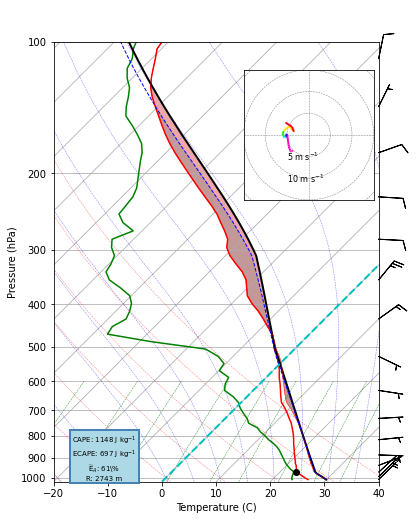

{'CAPE': 1200.5199092628827, 'CIN': -118.49420637945175, 'LFC': 6729.825818711854, 'EL': 15653.596287904922, 'NCAPE': 2815.801051837787, 'V_SR': 8.420828, 'Etilde': 0.666142648831671, 'varepsilon': 1.5569265463848674e-05, 'radius': 2885.1502772737595, 'ECAPE': 799.717512331534}
(137,)
(137,)
CAPE %-tile 80


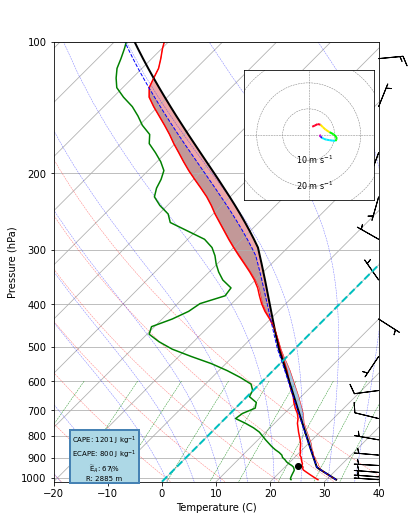

{'CAPE': 1406.9412081505589, 'CIN': -23.55126127864365, 'LFC': 1646.524468919914, 'EL': 15693.578519342162, 'NCAPE': 2040.4908925141247, 'V_SR': 8.114761, 'Etilde': 0.6882086424876958, 'varepsilon': 2.019621351672792e-05, 'radius': 2533.1885948354866, 'ECAPE': 968.2690989212947}
(137,)
(137,)
CAPE %-tile 90


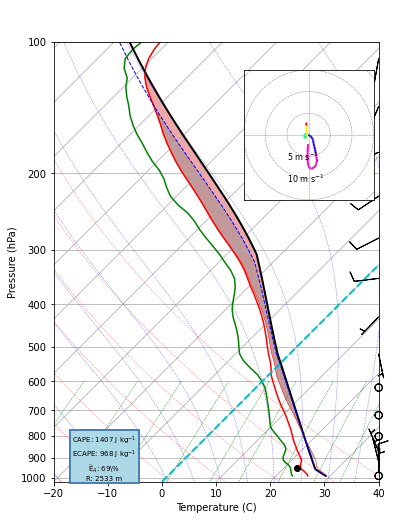

{'CAPE': 3552.5051872417544, 'CIN': -6.496244364579997, 'LFC': 1139.426982300664, 'EL': 17127.25459714981, 'NCAPE': 2425.5981761313196, 'V_SR': 8.551639, 'Etilde': 0.6230598277850355, 'varepsilon': 3.4902749563476763e-05, 'radius': 1926.959913898145, 'ECAPE': 2213.423270168293}
(137,)
(137,)
CAPE %-tile 100


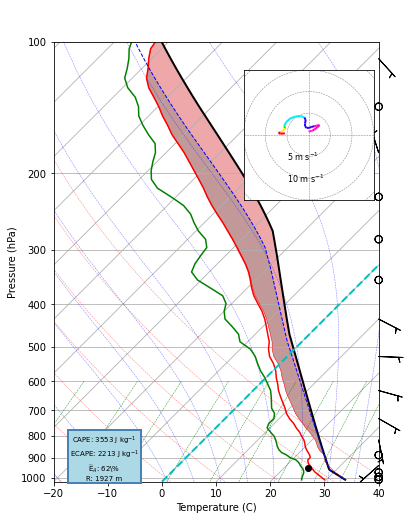

In [86]:
for i, ecape_val in enumerate(ecape_ptiles):
    lat_idx, lon_idx = np.where(output[-1] == ecape_val)
    lat_idx *= 10
    lon_idx *= 10
    #plt.figure()
    plot_profile(ds, comp_alt, lon_idx[0], lat_idx[0])
    #ax = plt.gca()
    print(f'CAPE %-tile {i * 10}')
    plt.show()